In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import xarray as xr

In [5]:
ds = xr.open_dataset('./Simulations/nemo_cice_iwdrag_2000_2017.nc')

In [6]:
print(ds)

<xarray.Dataset> Size: 4GB
Dimensions:           (time: 216, bnds: 2, y: 129, x: 104, nc: 5)
Coordinates:
  * time              (time) object 2kB 2000-01-17 00:00:00 ... 2017-12-17 00...
    TLON              (y, x) float32 54kB ...
    TLAT              (y, x) float32 54kB ...
Dimensions without coordinates: bnds, y, x, nc
Data variables: (12/125)
    time_bnds         (time, bnds) object 3kB ...
    hi_m              (time, y, x) float64 23MB ...
    hs_m              (time, y, x) float64 23MB ...
    Tsfc_m            (time, y, x) float64 23MB ...
    aice_m            (time, y, x) float64 23MB ...
    sice_m            (time, y, x) float64 23MB ...
    ...                ...
    strocnx_m         (time, y, x) float64 23MB ...
    strocny_m         (time, y, x) float64 23MB ...
    strintx_m         (time, y, x) float64 23MB ...
    strinty_m         (time, y, x) float64 23MB ...
    sig1_m            (time, y, x) float64 23MB ...
    sig2_m            (time, y, x) float64 23MB ...


/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/1018102081.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  indices = np.arange(0, ds.dims['time'], 1)
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/1018102081.py:82: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  h = m.pcolormesh(x, y, data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/1018102081.py:82: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasin

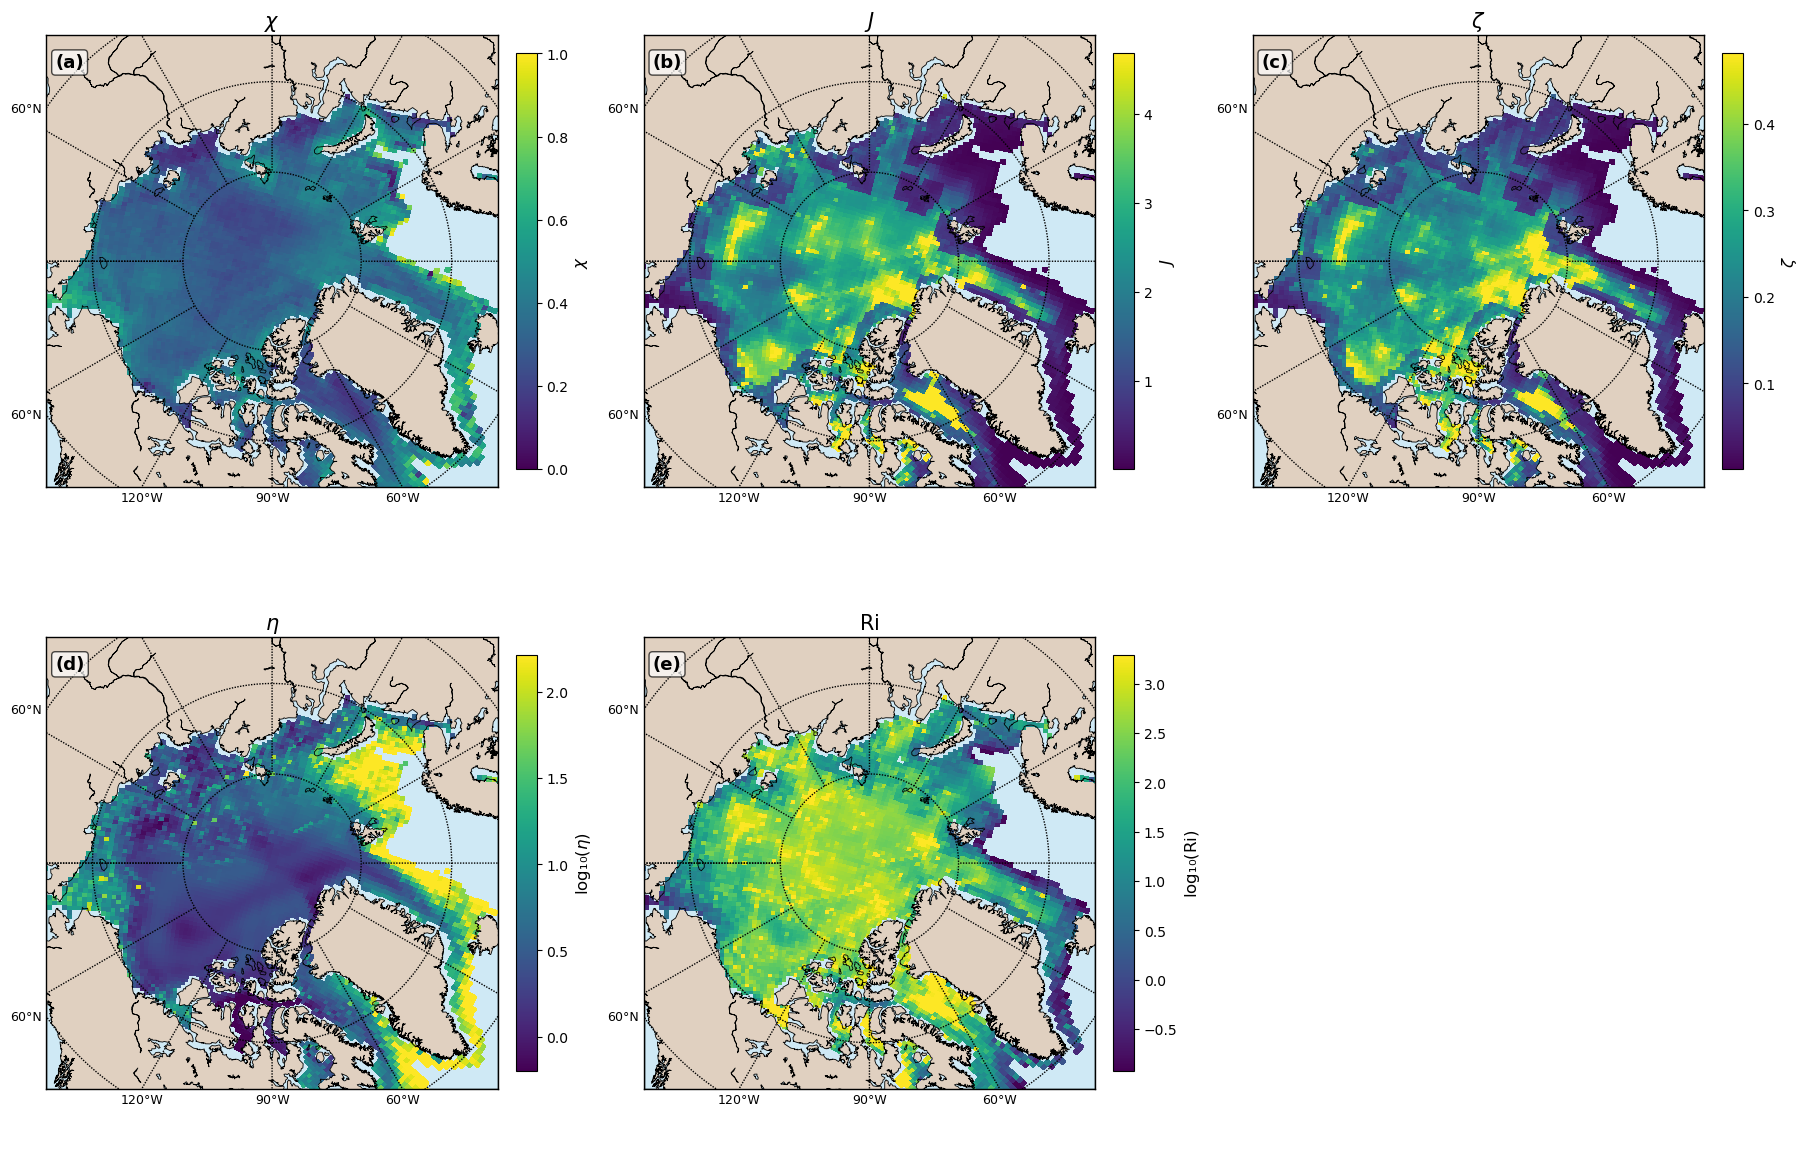

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr

indices = np.arange(0, ds.dims['time'], 1)

# Variables
u_ice = ds['uvel_m'].isel(time=indices)
v_ice = ds['vvel_m'].isel(time=indices)
u_ocn = ds['uocn_m'].isel(time=indices)
v_ocn = ds['vocn_m'].isel(time=indices)
L_raw = ds['dkeel_m'].isel(time=indices)
L = L_raw.where(L_raw > 0)
N2 = ds['N2_m'].isel(time=indices).where(ds['N2_m'].isel(time=indices) > 0)
N = np.sqrt(N2)

u0 = np.sqrt((u_ice - u_ocn)**2 + (v_ice - v_ocn)**2)
u0 = u0.where(u0 > 0)
k0 = (2 * np.pi / L).where(L > 0)

lat_rad = np.deg2rad(ds.TLAT)
Omega = 7.2921e-5
f = 2 * Omega * np.sin(lat_rad)
f_over_N = (f / N).where(np.isfinite(f / N))

# χ
chi = (u0 * k0) / N
chi_filtered = chi.where((chi >= f_over_N) & (chi <= 1))
chi_avg = chi_filtered.mean(dim='time', skipna=True)

# J
h0 = ds['hkeel_m'].isel(time=indices)
J = (N * h0) / u0
J_filtered = J.where((chi_avg >= 0.0) & (chi_avg <= 1.0))
J_avg = J_filtered.mean(dim='time', skipna=True)

# ζ
zeta_avg = (chi_avg * J_avg) / np.pi

# η
h_mix = ds['hmix_m'].isel(time=indices)
h_keel = ds['hkeel_m'].isel(time=indices).where(ds['hkeel_m'].isel(time=indices) != 0)
eta = (h_mix / h_keel).where((chi_avg >= 0.0) & (chi_avg <= 1.0))
eta_avg = eta.mean(dim='time', skipna=True)

# Ri
deltaB = ds['deltaB_m'].isel(time=indices)
Ri = (deltaB / (k0 * u0**2)).where((chi_avg >= 0) & (chi_avg <= 1))
Ri_avg = Ri.mean(dim='time', skipna=True)

# Coordinates
ny, nx = chi_avg.shape
lon = ds.TLON.isel(y=slice(0, ny), x=slice(0, nx)).values
lat = ds.TLAT.isel(y=slice(0, ny), x=slice(0, nx)).values

# Helpers
def qlim(arr, lo=0.01, hi=0.95):
    a = np.asarray(arr)
    vmin = np.nanquantile(a, lo)
    vmax = np.nanquantile(a, hi)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        vmin, vmax = np.nanmin(a), np.nanmax(a)
    return vmin, vmax

def draw_map(ax, data2d, title, cbar_label, vmin=None, vmax=None, cmap='viridis',
             subplot_label=None, log_scale=False):
    m = Basemap(projection='npstere', boundinglat=65, lon_0=270, resolution='l', ax=ax)
    x, y = m(lon, lat)
    m.drawcoastlines(linewidth=0.6)
    m.fillcontinents(color='#e0d0c0', lake_color='#cfe9f5')
    m.drawmapboundary(fill_color='#cfe9f5')
    m.drawparallels(np.arange(60, 91, 10), labels=[1,0,0,0], fontsize=9)
    m.drawmeridians(np.arange(-180, 181, 30), labels=[0,0,0,1], fontsize=9)

    data = np.asarray(data2d)
    if log_scale:
        data = np.log10(np.where(data > 0, data, np.nan))
        cbar_label = f'log₁₀({cbar_label})'
    if vmin is None or vmax is None:
        vmin, vmax = qlim(data, 0.01, 0.95)
    h = m.pcolormesh(x, y, data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(h, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label(cbar_label, fontsize=12)
    ax.set_title(title, fontsize=15)
    if subplot_label:
        ax.text(0.02, 0.96, subplot_label, transform=ax.transAxes,
                fontsize=13, fontweight='bold', va='top', ha='left',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', alpha=0.7))

# Plot 5 fields
fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

draw_map(axes[0,0], chi_avg.values, r'$\chi$', r'$\chi$', vmin=0.0, vmax=1.0,
         cmap='viridis', subplot_label='(a)')
draw_map(axes[0,1], J_avg.values, r'$J$', r'$J$',
         *qlim(J_avg.values, 0.01, 0.95), cmap='viridis', subplot_label='(b)')
draw_map(axes[0,2], zeta_avg.values, r'$\zeta$', r'$\zeta$',
         *qlim(zeta_avg.values, 0.01, 0.95), cmap='viridis', subplot_label='(c)')
draw_map(axes[1,0], eta_avg.values, r'$\eta$', r'$\eta$',
         log_scale=True, cmap='viridis', subplot_label='(d)')
draw_map(axes[1,1], Ri_avg.values, r'$\mathrm{Ri}$', r'$\mathrm{Ri}$',
         log_scale=True, cmap='viridis', subplot_label='(e)')
axes[1,2].axis('off')
plt.show()


# Elminate outliers

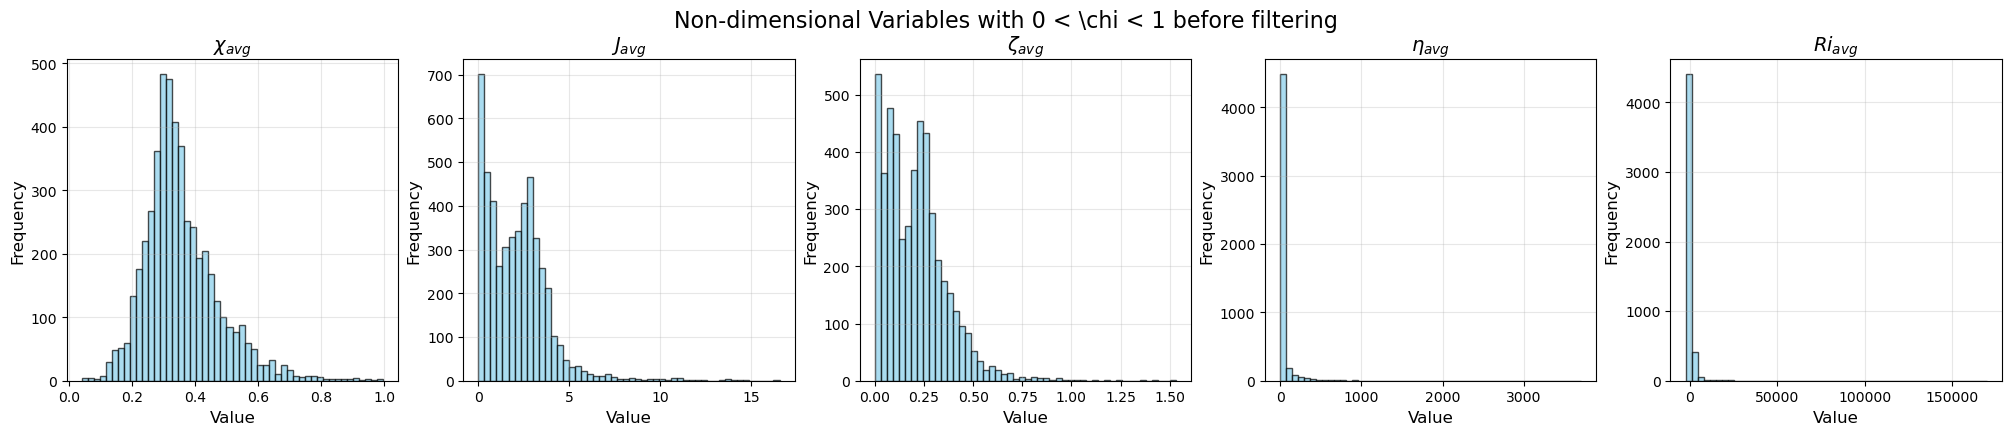

In [8]:
import numpy as np

import matplotlib.pyplot as plt

# Flatten the data and remove NaN values for each variable
variables = [chi_avg, J_avg, zeta_avg, eta_avg, Ri_avg]
titles = [r'$\chi_{avg}$', r'$J_{avg}$', r'$\zeta_{avg}$', r'$\eta_{avg}$', r'$Ri_{avg}$']

cleaned_data = [var.values.flatten()[np.isfinite(var.values.flatten())] for var in variables]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)

for ax, data, title in zip(axes, cleaned_data, titles):
    ax.hist(data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(alpha=0.3)

plt.suptitle('Non-dimensional Variables with 0 < \chi < 1 before filtering', fontsize=16, y=1.05)
plt.show()

In [9]:
final_chi_avg = chi_avg
final_J_avg = J_avg.where((J_avg <= np.nanquantile(J_avg, 0.95)))
final_zeta_avg = zeta_avg.where((zeta_avg >= np.nanquantile(zeta_avg, 0.00)) &
                            (zeta_avg <= np.nanquantile(zeta_avg, 0.95)))
final_eta_avg = eta_avg.where((eta_avg >= np.nanquantile(eta_avg, 0.0)) &
                            (eta_avg <= np.nanquantile(eta_avg, 0.95)))
final_Ri_avg = Ri_avg.where((Ri_avg >= np.nanquantile(Ri_avg, 0.0)) & 
                            (Ri_avg <= np.nanquantile(Ri_avg, 0.95)))

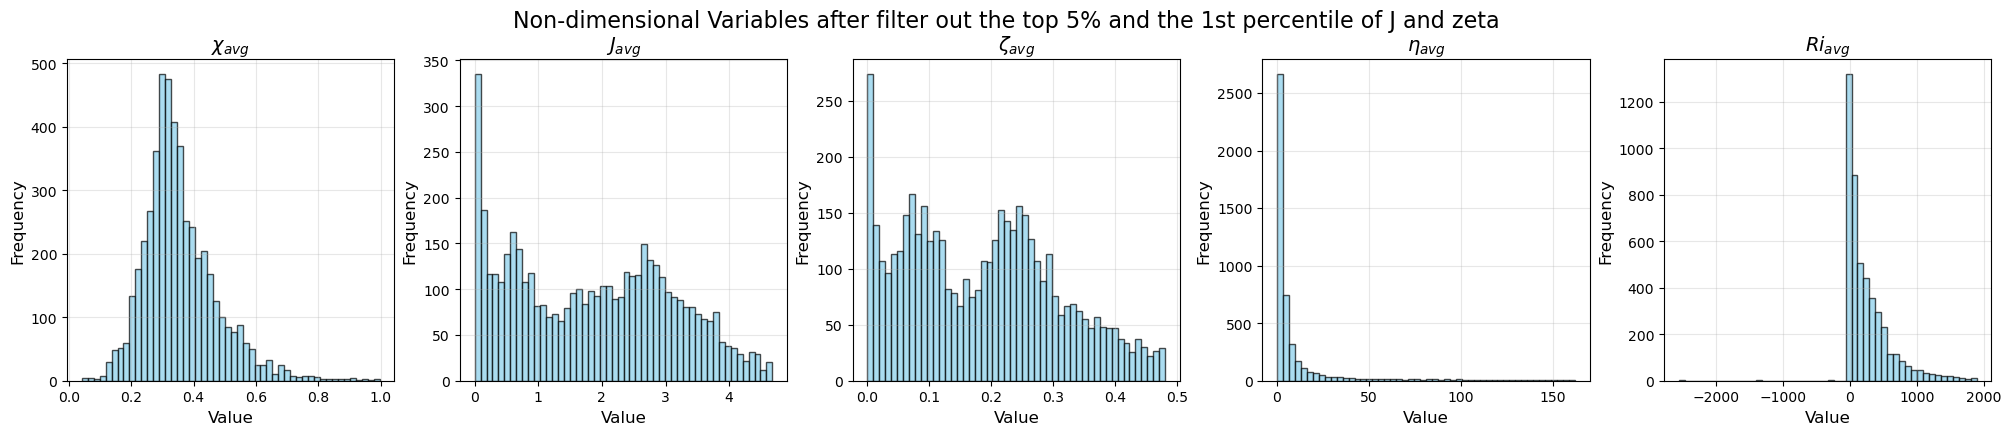

In [10]:
import numpy as np

import matplotlib.pyplot as plt

# Flatten the data and remove NaN values for each variable
variables = [final_chi_avg, final_J_avg, final_zeta_avg, final_eta_avg, final_Ri_avg]
titles = [r'$\chi_{avg}$', r'$J_{avg}$', r'$\zeta_{avg}$', r'$\eta_{avg}$', r'$Ri_{avg}$']

cleaned_data = [var.values.flatten()[np.isfinite(var.values.flatten())] for var in variables]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)

for ax, data, title in zip(axes, cleaned_data, titles):
    ax.hist(data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(alpha=0.3)

plt.suptitle('Non-dimensional Variables after filter out the top 5% and the 1st percentile of J and zeta', fontsize=16, y=1.05)
plt.show()

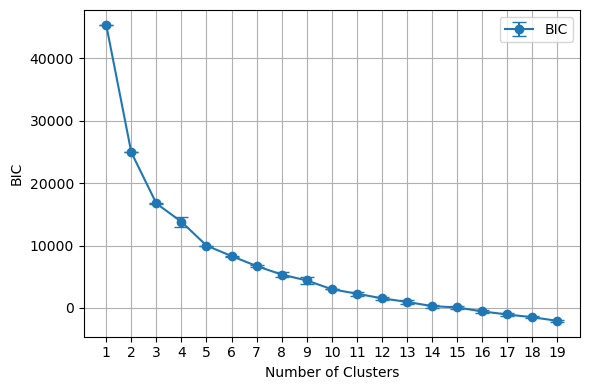

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Stack all features
features = [final_chi_avg, final_J_avg, final_zeta_avg, final_eta_avg, final_Ri_avg]
flattened = [v.values.flatten() for v in features]
X = np.stack(flattened, axis=1)
mask = np.all(np.isfinite(X), axis=1)
X_clean = X[mask]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# BIC calculation with repetitions
n_repeats = 3
n_components_range = range(1, 20)
bics = np.zeros((n_repeats, len(n_components_range)))

for i in range(n_repeats):
    for j, n in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=i)
        gmm.fit(X_scaled)
        bics[i, j] = gmm.bic(X_scaled)

# Mean & std
bic_mean = bics.mean(axis=0)
bic_std = bics.std(axis=0)

# Plot
plt.figure(figsize=(6, 4))
plt.errorbar(
    n_components_range, bic_mean, yerr=bic_std,
    fmt='o-', capsize=5, label='BIC'
)
plt.xticks(ticks=n_components_range)  # ← ensure integer ticks
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/2909821279.py:47: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = m.pcolormesh(x, y, cluster_map, cmap=cmap, norm=norm, shading='auto')


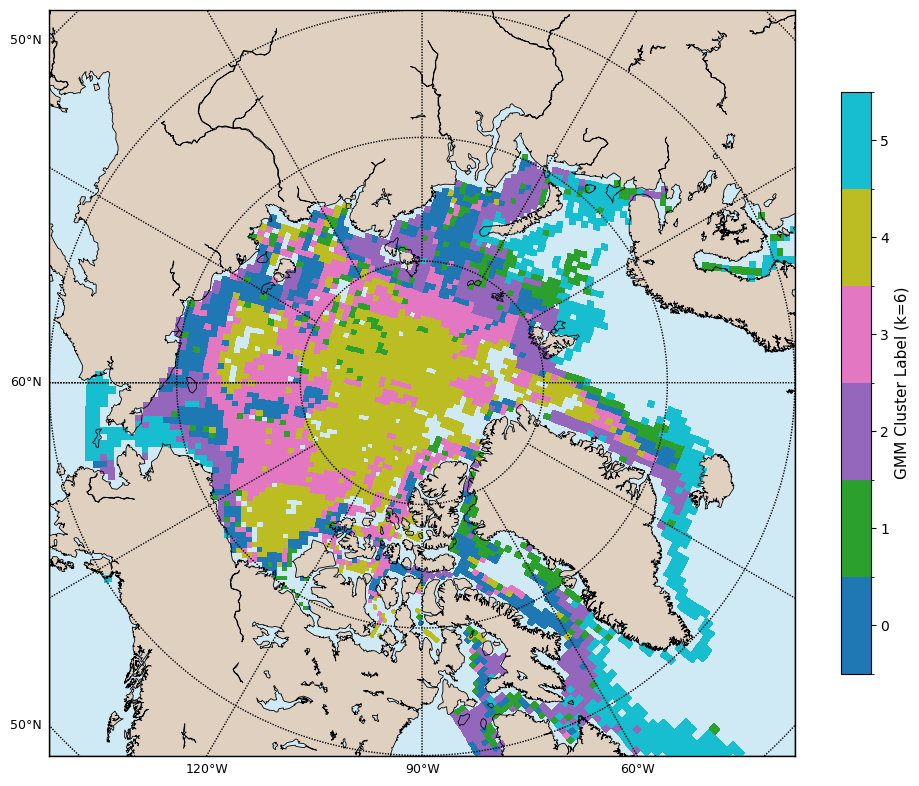

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors
import numpy as np

# 1. Prepare Data
variables = [final_chi_avg, final_J_avg, final_zeta_avg, final_eta_avg, final_Ri_avg]
flattened = [v.values.flatten() for v in variables]
X = np.stack(flattened, axis=1)

valid_mask = np.all(np.isfinite(X), axis=1)
X_clean = X[valid_mask]

# 2. Fit GMM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

n_clusters = 6
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
labels = gmm.fit_predict(X_scaled)

# 3. Map Labels Back to Grid
cluster_map = np.full(flattened[0].shape, np.nan)
cluster_map[valid_mask] = labels
cluster_map = cluster_map.reshape(final_chi_avg.shape)

lon = ds.TLON.isel(y=slice(0, cluster_map.shape[0]), x=slice(0, cluster_map.shape[1])).values
lat = ds.TLAT.isel(y=slice(0, cluster_map.shape[0]), x=slice(0, cluster_map.shape[1])).values

# 4. Plot
plt.figure(figsize=(10, 10))
m = Basemap(projection='npstere', boundinglat=60, lon_0=270, resolution='l')

x, y = m(lon, lat)
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='#e0d0c0', lake_color='#cfe9f5')
m.drawmapboundary(fill_color='#cfe9f5')
m.drawparallels(np.arange(50, 91, 10), labels=[1,0,0,0], fontsize=9)
m.drawmeridians(np.arange(-180, 181, 30), labels=[0,0,0,1], fontsize=9)

# 5. Colorbar and Labels
cmap = plt.get_cmap('tab10', n_clusters)
norm = mcolors.BoundaryNorm(boundaries=np.arange(n_clusters+1)-0.5, ncolors=n_clusters)

cs = m.pcolormesh(x, y, cluster_map, cmap=cmap, norm=norm, shading='auto')

cbar = plt.colorbar(cs, ticks=np.arange(n_clusters), shrink=0.6, pad=0.05)
cbar.set_label('GMM Cluster Label (k=6)', fontsize=11)

plt.tight_layout()
plt.show()


# Posterior Confidence

/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/1529039726.py:73: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  h = m.pcolormesh(x, y, data2d, shading='auto', cmap=cmap, norm=norm)
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/1529039726.py:73: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  h = m.pcolormesh(x, y, data2d, shading='auto', cmap=cmap, norm=norm)
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/1529039726.py:73: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically i

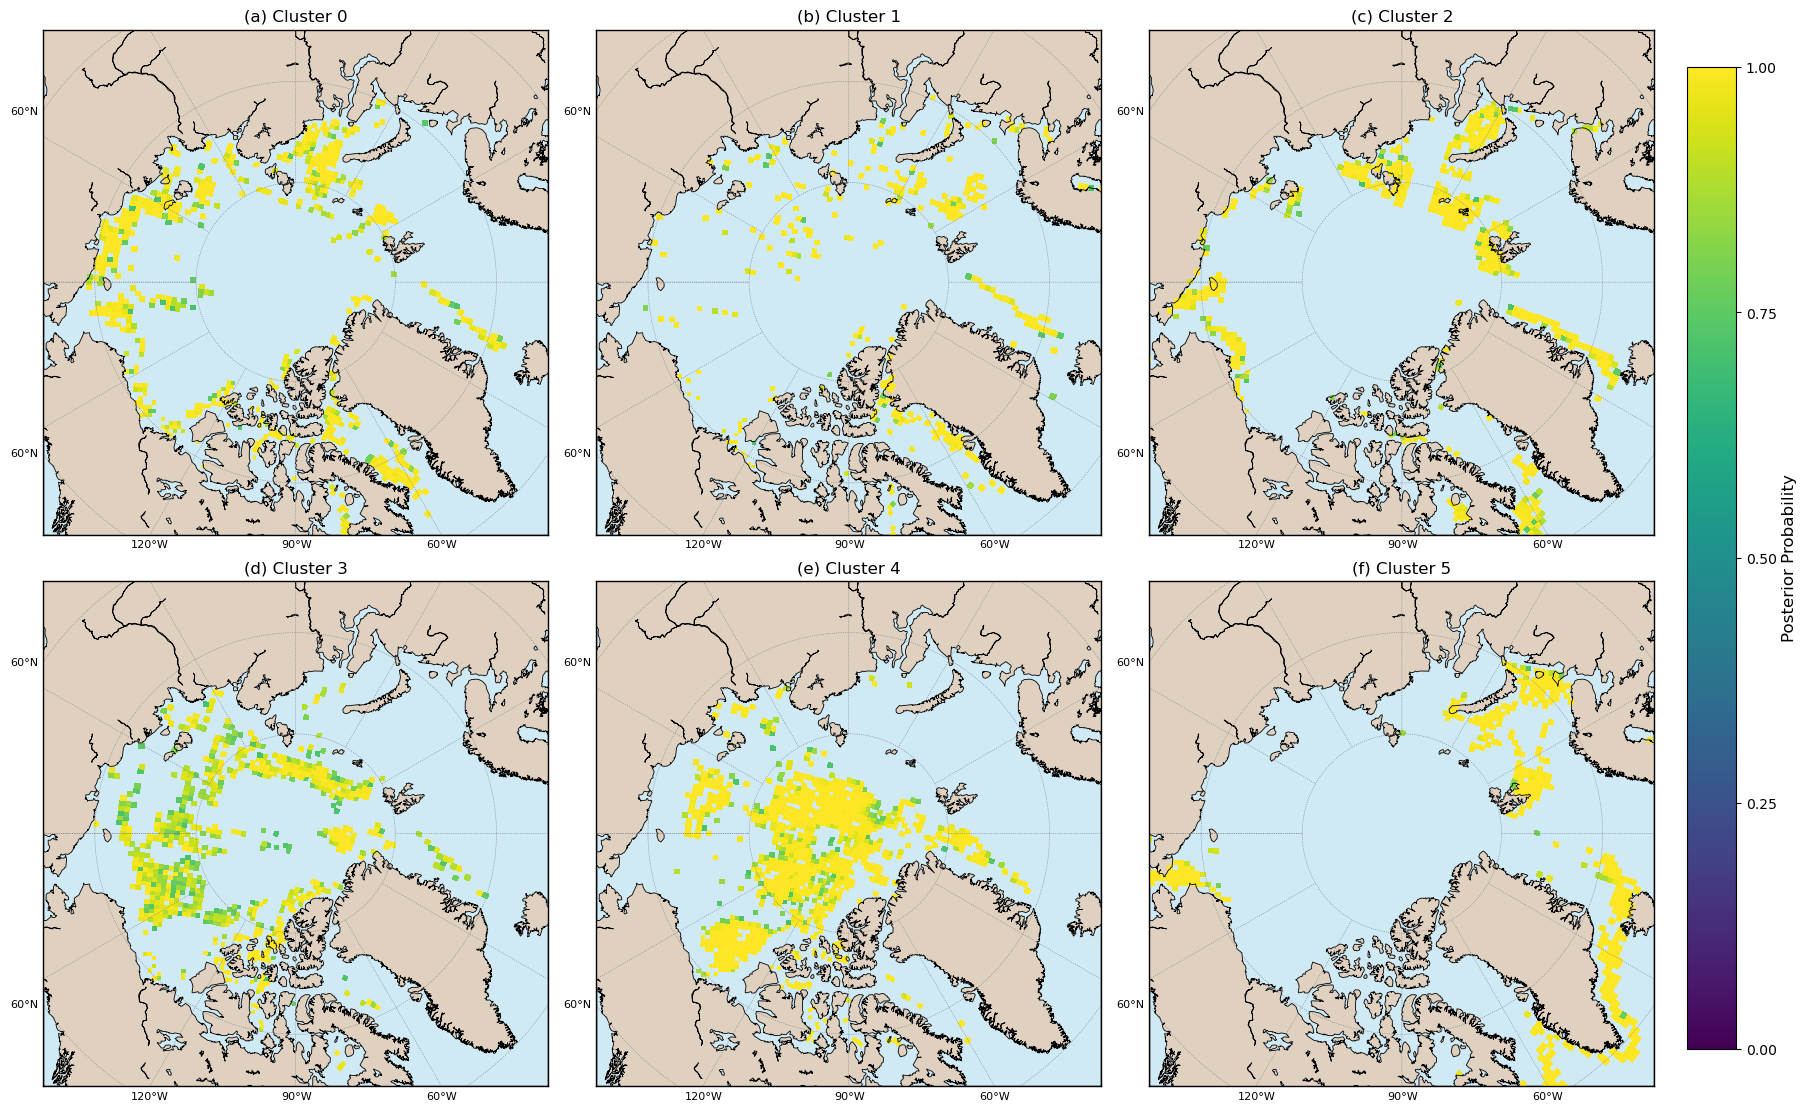

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap

# ==== GMM setup ====
variables = [final_chi_avg, final_J_avg, final_zeta_avg, final_eta_avg, final_Ri_avg]
flattened = [v.values.flatten() for v in variables]
X = np.stack(flattened, axis=1)
valid_mask = np.all(np.isfinite(X), axis=1)
X_clean = X[valid_mask]

# Scale and fit
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

labels = gmm.predict(X_scaled)
probs  = gmm.predict_proba(X_scaled)  # shape: (n_points, n_clusters)

# ==== Reconstruct full maps ====
ny, nx = final_chi_avg.shape
n_pixels = ny * nx
lon = ds.TLON.values
lat = ds.TLAT.values

# Setup plot
fig, axes = plt.subplots(2, 3, figsize=(18, 11), constrained_layout=True)
axes = axes.ravel()
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)

# Colorbar config
cmap = plt.cm.viridis
cb_ticks = [0.0, 0.25, 0.5, 0.75, 1.0]

# Plot each cluster's high-confidence members only
for k in range(6):
    ax = axes[k]

    # Mask: points assigned to cluster k with confidence ≥ 0.7
    high_conf_mask = (labels == k) & (probs[:, k] >= 0.7)

    # Initialize nan array and fill only high-conf points
    data = np.full(n_pixels, np.nan)
    data[valid_mask] = np.where(high_conf_mask, probs[:, k], np.nan)
    data2d = data.reshape((ny, nx))

    # Draw map
    m = Basemap(projection='npstere', boundinglat=65, lon_0=270, resolution='l', ax=ax)
    x, y = m(lon, lat)
    m.drawcoastlines(linewidth=0.6)
    m.fillcontinents(color='#e0d0c0', lake_color='#cfe9f5')
    m.drawmapboundary(fill_color='#cfe9f5')

    # ---- Lat/Lon grid (consistent style) ----
    # Parallels every 10°, meridians every 30°, subtle gray dashed lines
    m.drawparallels(
        np.arange(50, 91, 10), labels=[1,0,0,0],
        color='gray', linewidth=0.4, dashes=[2,2], fontsize=8
    )
    m.drawmeridians(
        np.arange(-180, 181, 30), labels=[0,0,0,1],
        color='gray', linewidth=0.4, dashes=[2,2], fontsize=8
    )
    # -----------------------------------------

    # Title & pcolormesh
    ax.set_title(f'({chr(97 + k)}) Cluster {k}', fontsize=12)
    h = m.pcolormesh(x, y, data2d, shading='auto', cmap=cmap, norm=norm)

# Shared colorbar
cbar = fig.colorbar(h, ax=axes.tolist(), fraction=0.03, pad=0.02)
cbar.set_label('Posterior Probability', fontsize=12)
cbar.set_ticks(cb_ticks)
plt.show()


# Box plot for each non-dimenional variables

/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/3848845177.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/3848845177.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/3848845177.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/x6/3ksd31kd0qlb8vzxm4gl87gr0000gn/T/ipykernel_94385/3848845177.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

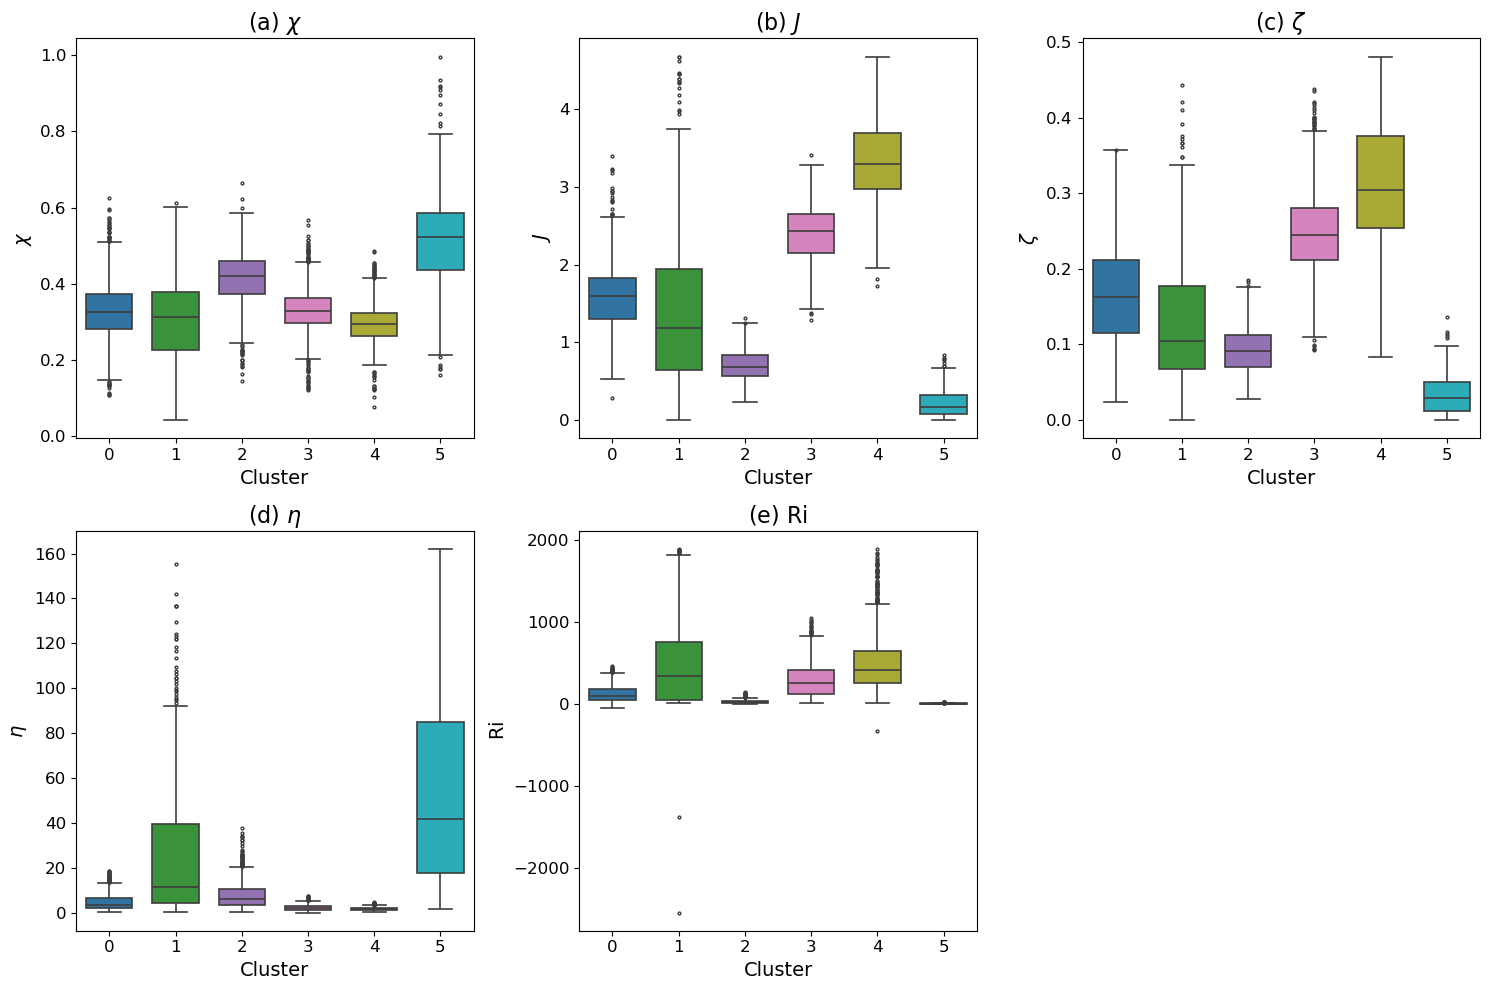

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Map-matching palette (0..5)
# ---------------------------
map_palette = ['#1f77b4', '#2ca02c', '#9467bd', '#e377c2', '#bcbd22', '#17becf']
cluster_order = [0, 1, 2, 3, 4, 5]
cluster_palette = {str(k): map_palette[k] for k in cluster_order}

# Variable names and math symbols
param_names = ['chi', 'J', 'zeta', 'eta', 'Ri']
sym = {
    'chi':  r'$\chi$',
    'J':    r'$J$',
    'zeta': r'$\zeta$',
    'eta':  r'$\eta$',
    'Ri':   r'$\mathrm{Ri}$',
}

# DataFrame from your arrays
cluster_data = pd.DataFrame(X_clean, columns=param_names)
cluster_data['Cluster'] = labels

# Ensure categorical order 0..5 so colors map correctly
cluster_data['Cluster'] = pd.Categorical(cluster_data['Cluster'],
                                         categories=cluster_order, ordered=True)

# ---- Plot ----
plt.figure(figsize=(15, 10))
letters = ['(a)', '(b)', '(c)', '(d)', '(e)']

for i, param in enumerate(param_names):
    ax = plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='Cluster',
        y=param,
        data=cluster_data,
        order=cluster_order,
        palette=cluster_palette,   # <- color match to map
        width=0.7,
        linewidth=1.2,
        fliersize=2
    )
    ax.set_title(f'{letters[i]} {sym[param]}', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_ylabel(sym[param], fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    # Make sure x ticks are 0..5 as integers
    ax.set_xticks(cluster_order)
    ax.set_xticklabels([str(k) for k in cluster_order], rotation=0)

# Remove unused 6th panel
plt.subplot(2, 3, 6).axis('off')

plt.tight_layout()
plt.show()


# Tables

In [25]:
import pandas as pd



df = pd.DataFrame(X_clean, columns=['chi', 'J', 'zeta', 'eta', 'Ri'])
df['Cluster'] = labels

# cluster mean and std
summary = df.groupby('Cluster').agg(['mean', 'std'])

# summary
print(summary)
summary.to_csv('gmm_cluster_summary.csv')


              chi                   J                zeta            \
             mean       std      mean       std      mean       std   
Cluster                                                               
0        0.327908  0.086956  1.594777  0.431218  0.167453  0.064642   
1        0.305216  0.104946  1.418350  1.061941  0.127756  0.088514   
2        0.413171  0.077644  0.706445  0.196645  0.093088  0.031817   
3        0.330129  0.065182  2.396435  0.336450  0.251209  0.060263   
4        0.294416  0.050989  3.340278  0.506600  0.314560  0.078477   
5        0.516029  0.127831  0.207155  0.160203  0.033123  0.025043   

               eta                     Ri              
              mean        std        mean         std  
Cluster                                                
0         5.063930   3.868049  125.491114   98.983201  
1        27.229879  33.057499  474.963791  532.321050  
2         8.452237   6.596569   28.980841   27.373859  
3         2.607528   1.2

# Pairwise variables plot

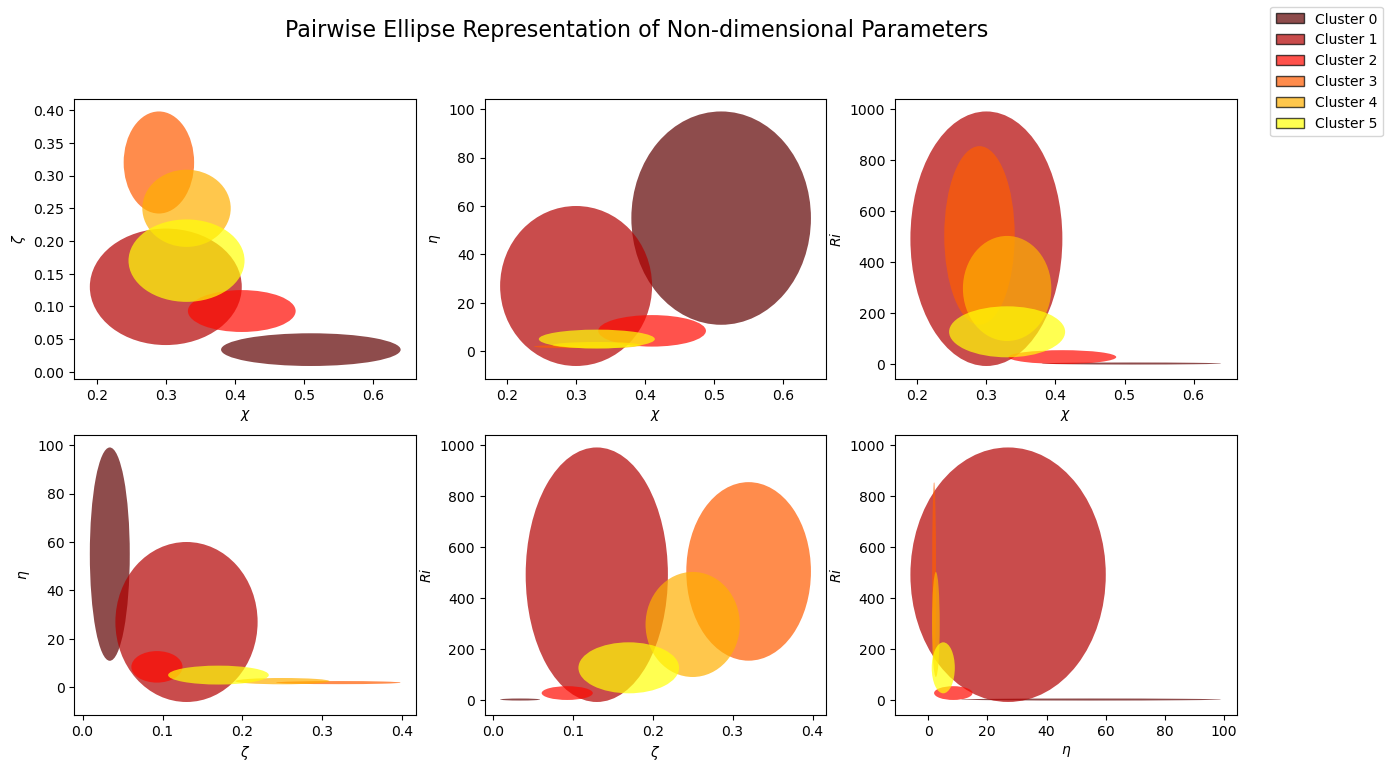

In [26]:
from matplotlib.patches import Ellipse

# Mean values of the non-dimensional numbers for each cluster
zeta = np.array([0.034, 0.13, 0.093, 0.32, 0.25, 0.17])
eta = np.array([55., 27., 8.5, 2.0, 2.6, 5.1])
Ri = np.array([3.7, 493., 29., 506., 298., 128.])
chi = np.array([0.51, 0.3, 0.41, 0.29, 0.33, 0.33])
J = np.array([0.21, 1.43, 0.71, 3.3, 2.4, 1.6])

# Standard deviation of the non-dimensional numbers for each cluster
zeta_std = np.array([0.025, 0.089, 0.032, 0.078, 0.059, 0.063])
eta_std = np.array([44., 33., 6.5, 0.64, 1.3, 3.9])
Ri_std = np.array([4., 499., 27., 350., 206., 100.])
chi_std = np.array([0.13, 0.11, 0.078, 0.051, 0.064, 0.084])
J_std = np.array([0.16, 1.07, 0.20, 0.49, 0.33, 0.43])

# Set an array of colors to have a colormap for each cluster
n = len(chi)
colors = plt.cm.hot(np.linspace(0,1,n+3))

fig, ax = plt.subplots(2,3)
ax[0,0].fill(chi[0], zeta[0], alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e0 = Ellipse((chi[0], zeta[0]), 2*chi_std[0], 2*zeta_std[0],
                     angle=0, linewidth=2, fill=True, fc=colors[1], alpha=0.7)
e1 = Ellipse((chi[1], zeta[1]), 2*chi_std[1], 2*zeta_std[1],
                     angle=0, linewidth=2, fill=True, fc=colors[2], alpha=0.7)
e2 = Ellipse((chi[2], zeta[2]), 2*chi_std[2], 2*zeta_std[2],
                     angle=0, linewidth=2, fill=True, fc=colors[3], alpha=0.7)
e3 = Ellipse((chi[3], zeta[3]), 2*chi_std[3], 2*zeta_std[3],
                     angle=0, linewidth=2, fill=True, fc=colors[4], alpha=0.7)
e4 = Ellipse((chi[4], zeta[4]), 2*chi_std[4], 2*zeta_std[4],
                     angle=0, linewidth=2, fill=True, fc=colors[5], alpha=0.7)
e5 = Ellipse((chi[5], zeta[5]), 2*chi_std[5], 2*zeta_std[5],
                     angle=0, linewidth=2, fill=True, fc=colors[6], alpha=0.7)

ax[0,0].add_patch(e0)
ax[0,0].add_patch(e1)
ax[0,0].add_patch(e2)
ax[0,0].add_patch(e3)
ax[0,0].add_patch(e4)
ax[0,0].add_patch(e5)

ax[0,1].fill(chi[0], eta[0], alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e0 = Ellipse((chi[0], eta[0]), 2*chi_std[0], 2*eta_std[0],
                     angle=0, linewidth=2, fill=True, fc=colors[1], alpha=0.7)
e1 = Ellipse((chi[1], eta[1]), 2*chi_std[1], 2*eta_std[1],
                     angle=0, linewidth=2, fill=True, fc=colors[2], alpha=0.7)
e2 = Ellipse((chi[2], eta[2]), 2*chi_std[2], 2*eta_std[2],
                     angle=0, linewidth=2, fill=True, fc=colors[3], alpha=0.7)
e3 = Ellipse((chi[3], eta[3]), 2*chi_std[3], 2*eta_std[3],
                     angle=0, linewidth=2, fill=True, fc=colors[4], alpha=0.7)
e4 = Ellipse((chi[4], eta[4]), 2*chi_std[4], 2*eta_std[4],
                     angle=0, linewidth=2, fill=True, fc=colors[5], alpha=0.7)
e5 = Ellipse((chi[5], eta[5]), 2*chi_std[5], 2*eta_std[5],
                     angle=0, linewidth=2, fill=True, fc=colors[6], alpha=0.7)

ax[0,1].add_patch(e0)
ax[0,1].add_patch(e1)
ax[0,1].add_patch(e2)
ax[0,1].add_patch(e3)
ax[0,1].add_patch(e4)
ax[0,1].add_patch(e5)

ax[0,2].fill(chi[0], Ri[0], alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e0 = Ellipse((chi[0], Ri[0]), 2*chi_std[0], 2*Ri_std[0],
                     angle=0, linewidth=2, fill=True, fc=colors[1], alpha=0.7)
e1 = Ellipse((chi[1], Ri[1]), 2*chi_std[1], 2*Ri_std[1],
                     angle=0, linewidth=2, fill=True, fc=colors[2], alpha=0.7)
e2 = Ellipse((chi[2], Ri[2]), 2*chi_std[2], 2*Ri_std[2],
                     angle=0, linewidth=2, fill=True, fc=colors[3], alpha=0.7)
e3 = Ellipse((chi[3], Ri[3]), 2*chi_std[3], 2*Ri_std[3],
                     angle=0, linewidth=2, fill=True, fc=colors[4], alpha=0.7)
e4 = Ellipse((chi[4], Ri[4]), 2*chi_std[4], 2*Ri_std[4],
                     angle=0, linewidth=2, fill=True, fc=colors[5], alpha=0.7)
e5 = Ellipse((chi[5], Ri[5]), 2*chi_std[5], 2*Ri_std[5],
                     angle=0, linewidth=2, fill=True, fc=colors[6], alpha=0.7)

ax[0,2].add_patch(e0)
ax[0,2].add_patch(e1)
ax[0,2].add_patch(e2)
ax[0,2].add_patch(e3)
ax[0,2].add_patch(e4)
ax[0,2].add_patch(e5)

ax[1,0].fill(zeta[0], eta[0], alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e0 = Ellipse((zeta[0], eta[0]), 2*zeta_std[0], 2*eta_std[0],
                     angle=0, linewidth=2, fill=True, fc=colors[1], alpha=0.7)
e1 = Ellipse((zeta[1], eta[1]), 2*zeta_std[1], 2*eta_std[1],
                     angle=0, linewidth=2, fill=True, fc=colors[2], alpha=0.7)
e2 = Ellipse((zeta[2], eta[2]), 2*zeta_std[2], 2*eta_std[2],
                     angle=0, linewidth=2, fill=True, fc=colors[3], alpha=0.7)
e3 = Ellipse((zeta[3], eta[3]), 2*zeta_std[3], 2*eta_std[3],
                     angle=0, linewidth=2, fill=True, fc=colors[4], alpha=0.7)
e4 = Ellipse((zeta[4], eta[4]), 2*zeta_std[4], 2*eta_std[4],
                     angle=0, linewidth=2, fill=True, fc=colors[5], alpha=0.7)
e5 = Ellipse((zeta[5], eta[5]), 2*zeta_std[5], 2*eta_std[5],
                     angle=0, linewidth=2, fill=True, fc=colors[6], alpha=0.7)

ax[1,0].add_patch(e0)
ax[1,0].add_patch(e1)
ax[1,0].add_patch(e2)
ax[1,0].add_patch(e3)
ax[1,0].add_patch(e4)
ax[1,0].add_patch(e5)

ax[1,1].fill(zeta[0], Ri[0], alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e0 = Ellipse((zeta[0], Ri[0]), 2*zeta_std[0], 2*Ri_std[0],
                     angle=0, linewidth=2, fill=True, fc=colors[1], alpha=0.7)
e1 = Ellipse((zeta[1], Ri[1]), 2*zeta_std[1], 2*Ri_std[1],
                     angle=0, linewidth=2, fill=True, fc=colors[2], alpha=0.7)
e2 = Ellipse((zeta[2], Ri[2]), 2*zeta_std[2], 2*Ri_std[2],
                     angle=0, linewidth=2, fill=True, fc=colors[3], alpha=0.7)
e3 = Ellipse((zeta[3], Ri[3]), 2*zeta_std[3], 2*Ri_std[3],
                     angle=0, linewidth=2, fill=True, fc=colors[4], alpha=0.7)
e4 = Ellipse((zeta[4], Ri[4]), 2*zeta_std[4], 2*Ri_std[4],
                     angle=0, linewidth=2, fill=True, fc=colors[5], alpha=0.7)
e5 = Ellipse((zeta[5], Ri[5]), 2*zeta_std[5], 2*Ri_std[5],
                     angle=0, linewidth=2, fill=True, fc=colors[6], alpha=0.7)

ax[1,1].add_patch(e0)
ax[1,1].add_patch(e1)
ax[1,1].add_patch(e2)
ax[1,1].add_patch(e3)
ax[1,1].add_patch(e4)
ax[1,1].add_patch(e5)

ax[1,2].fill(eta[0], Ri[0], alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e0 = Ellipse((eta[0], Ri[0]), 2*eta_std[0], 2*Ri_std[0],
                     angle=0, linewidth=2, fill=True, fc=colors[1], alpha=0.7)
e1 = Ellipse((eta[1], Ri[1]), 2*eta_std[1], 2*Ri_std[1],
                     angle=0, linewidth=2, fill=True, fc=colors[2], alpha=0.7)
e2 = Ellipse((eta[2], Ri[2]), 2*eta_std[2], 2*Ri_std[2],
                     angle=0, linewidth=2, fill=True, fc=colors[3], alpha=0.7)
e3 = Ellipse((eta[3], Ri[3]), 2*eta_std[3], 2*Ri_std[3],
                     angle=0, linewidth=2, fill=True, fc=colors[4], alpha=0.7)
e4 = Ellipse((eta[4], Ri[4]), 2*eta_std[4], 2*Ri_std[4],
                     angle=0, linewidth=2, fill=True, fc=colors[5], alpha=0.7)
e5 = Ellipse((eta[5], Ri[5]), 2*eta_std[5], 2*Ri_std[5],
                     angle=0, linewidth=2, fill=True, fc=colors[6], alpha=0.7)

ax[1,2].add_patch(e0)
ax[1,2].add_patch(e1)
ax[1,2].add_patch(e2)
ax[1,2].add_patch(e3)
ax[1,2].add_patch(e4)
ax[1,2].add_patch(e5)


ax[0,0].set(xlabel='$\chi$', ylabel='$\zeta$')
ax[0,1].set(xlabel='$\chi$', ylabel='$\eta$')
ax[0,2].set(xlabel='$\chi$', ylabel='$Ri$')
ax[1,0].set(xlabel='$\zeta$', ylabel='$\eta$')
ax[1,1].set(xlabel='$\zeta$', ylabel='$Ri$')
ax[1,2].set(xlabel='$\eta$', ylabel='$Ri$')
fig.suptitle('Pairwise Ellipse Representation of Non-dimensional Parameters', fontsize=16)

from matplotlib.patches import Ellipse, Patch


legend_elements = [
    Patch(facecolor=colors[1], edgecolor='k', alpha=0.7, label='Cluster 0'),
    Patch(facecolor=colors[2], edgecolor='k', alpha=0.7, label='Cluster 1'),
    Patch(facecolor=colors[3], edgecolor='k', alpha=0.7, label='Cluster 2'),
    Patch(facecolor=colors[4], edgecolor='k', alpha=0.7, label='Cluster 3'),
    Patch(facecolor=colors[5], edgecolor='k', alpha=0.7, label='Cluster 4'),
    Patch(facecolor=colors[6], edgecolor='k', alpha=0.7, label='Cluster 5'),
]

fig.legend(handles=legend_elements, loc='upper right', fontsize=10)

fig.set_size_inches(15,8)